# <a id='toc1_'></a>[Проверка работы оборудования и регистрации респондентов на пиплметре](#toc0_)

Необходимо:

* проанализировать количество ситуаций (абс, %), когда прибор фактически выключен (данные в таблице `src_OnOff`), а респондент утверждает, что включен
* проанализировать количество ситуаций (абс, %), когда прибор фактически включен (данные в таблице `src_OnOff`), а респондент утверждает, что выключен
* выделить ДХ с размером более 1 человека, среди них ситуации, телевизор фактически включен, респондент по данным опроса находится в комнате с включенным телевизором, регистрации нет, а у других респондентов в этом ДХ регистрация на этом телевизоре есть. Необходимо сгруппировать результат в зависимости от размера ДХ.

Для работы получены 2 файла:

`src_OnOff.csv` - данные по фактическому включению/выключению пиплметра (измерительное устройство для фиксации телесмотрения).

Описание полей данных:

* `PassportNumber` - номер регистрационого паспорта владельца.
* `UnitNumber` - номер телевизора в домохозяйстве (ДХ).
* `DeviceState` - cтатус работы телевизора 'ON'/'OFF'.
* `Begin` - дата и время его включения телевизора.
* `End` - дата и время его выключения телевизора.

`src_survey.csv` - данные с результатами опроса клиентов телевизионной компании.

Описание полей данных:

* `code` - код опроса клиента (порядковый номер),
* `passport` - номер регистрационого паспорта владельца телевизора,
* `button` - идентификатор респондента,
* `tv state` - статус телевизора по утверждению респондента,
* `unit` - номер телевизора в домохозяйстве,
* `day` - дата опроса,
* `cs_start` - время начала опроса,
* `cs_finish` - время окончания опроса,
* `see` - наличие фактической регистрации на пиплметре,
* `display` - наличие респондента в комнате с телевизором согласно опросу,
* `Кол-во человек в семье 4+` - размер ДХ, количество жильцов в доме.

**Содержание**<a id='toc0_'></a>    
- [Проверка работы оборудования и регистрации респондентов на пиплметре](#toc1_)    
  - [Загрузка данных](#toc1_1_)    
  - [Предобработка](#toc1_2_)    
  - [Анализ](#toc1_3_)    
  - [Общий вывод](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Загрузка данных](#toc0_)

In [1]:
# импорт библиотек
import pandas as pd 
from datetime import datetime
import tqdm
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import warnings
warnings.filterwarnings("ignore")

In [2]:
# настроим вид таблиц
pd.set_option("display.max_rows", 250)
pd.set_option("display.max_columns", 50)

In [3]:
# отображение основной информациии
onoff = pd.read_excel('src_OnOff.xlsx')
display(onoff.head())
display(onoff.info())

,PassportNumber,UnitNumber,DeviceState,Begin,End
0,10100003,0,OFF,2022-02-07 02:00:00.000,2022-02-08 02:00:00.000
1,10100003,0,OFF,2022-02-08 02:00:00.000,2022-02-08 11:48:42.000
2,10100003,0,ON,2022-02-08 11:48:42.000,2022-02-08 12:36:55.000
3,10100003,0,OFF,2022-02-08 12:36:55.000,2022-02-08 22:05:17.000
4,10100003,0,ON,2022-02-08 22:05:17.000,2022-02-08 23:48:03.000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642134 entries, 0 to 642133
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   PassportNumber  642134 non-null  int64 
 1   UnitNumber      642134 non-null  int64 
 2   DeviceState     642134 non-null  object
 3   Begin           642134 non-null  object
 4   End             642134 non-null  object
dtypes: int64(2), object(3)
memory usage: 24.5+ MB


None

In [4]:
# отображение основной информациии
sur = pd.read_excel('src_survey.xlsx')
display(sur.head())
display(sur.info())

,code,passport,button,tv state,unit,day,cs_start,cs_finish,see,display,Кол-во человек в семье 4+
0,258104,1204558,А,выключен,0,07.02.22,16:25:18,16:26:09,нет регистрации,нет в комнате,1
1,258106,1205697,Б,включён,0,07.02.22,16:50:18,16:53:17,нет регистрации,в комнате,3
2,258106,1205697,А,включён,0,07.02.22,16:50:18,16:53:17,нет регистрации,нет в комнате,3
3,258106,1205697,В,включён,0,07.02.22,16:50:18,16:53:17,нет регистрации,в комнате,3
4,258109,1206994,А,выключен,1,2022-02-08 00:00:00,03:05:31,03:06:58,нет регистрации,нет в комнате,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   code                       207 non-null    int64 
 1   passport                   207 non-null    int64 
 2   button                     207 non-null    object
 3   tv state                   207 non-null    object
 4   unit                       207 non-null    int64 
 5   day                        207 non-null    object
 6   cs_start                   207 non-null    object
 7   cs_finish                  207 non-null    object
 8   see                        207 non-null    object
 9   display                    207 non-null    object
 10  Кол-во человек в семье 4+  207 non-null    int64 
dtypes: int64(4), object(7)
memory usage: 17.9+ KB


None

В файле src_OnOff.csv находится 642_134 записи по фактическому включению/выключению пиплметра, а в файле src_survey.csv - выборка из 207 записей с результатами опроса клиентов телевизионной компании.

## <a id='toc1_2_'></a>[Предобработка](#toc0_)

In [5]:
# отображение основной информации
list_df = (onoff, sur)
for list_df in list_df:
    display('_____________информация________________')
    display(list_df.info())
    display('______________статистика_______________')
    display(list_df.describe().T)
    display('______________выборка__________________')
    display(list_df.sample(5))
    display('___________конец таблицы_______________')
    display(list_df.tail())
    display('_____________пропуски__________________')
    display(list_df.isna().sum().reset_index())
    display('_____________дубликаты_________________')
    display(list_df.duplicated().sum())
    display('доля пропущенных значений по каждому из столбцов')
    display(list_df.isnull().mean().reset_index())
    display('_______число уникальных значений_______')
    display(list_df.nunique())
    display('_________________КОНЕЦ________________')

'_____________информация________________'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642134 entries, 0 to 642133
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   PassportNumber  642134 non-null  int64 
 1   UnitNumber      642134 non-null  int64 
 2   DeviceState     642134 non-null  object
 3   Begin           642134 non-null  object
 4   End             642134 non-null  object
dtypes: int64(2), object(3)
memory usage: 24.5+ MB


None

'______________статистика_______________'

,count,mean,std,min,25%,50%,75%,max
PassportNumber,642134.0,5.953429e+06,5.894439e+06,100657.0,1210798.0,3400262.0,10400265.0,19900450.0
UnitNumber,642134.0,4.385751e-01,6.726274e-01,0.0,0.0,0.0,1.0,6.0


'______________выборка__________________'

,PassportNumber,UnitNumber,DeviceState,Begin,End
3670,10100335,0,OFF,2022-02-09 10:12:46.000,2022-02-09 10:13:27.000
550939,5500236,1,OFF,2022-02-07 18:15:23.000,2022-02-07 22:32:26.000
78991,14600827,0,OFF,2022-02-15 13:35:23.000,2022-02-15 14:05:18.000
411568,301473,0,ON,2022-02-14 22:35:04.000,2022-02-14 23:00:10.000
597481,7800592,1,ON,2022-02-14 13:36:21.000,2022-02-14 16:50:16.000


'___________конец таблицы_______________'

,PassportNumber,UnitNumber,DeviceState,Begin,End
642129,502286,0,OFF,2022-02-15 20:16:01.000,2022-02-15 20:53:31.000
642130,502286,0,ON,2022-02-15 20:53:31.000,2022-02-15 21:43:15.000
642131,502286,0,OFF,2022-02-15 21:43:15.000,2022-02-15 22:09:59.000
642132,502286,0,ON,2022-02-15 22:09:59.000,2022-02-15 22:19:33.000
642133,502286,0,OFF,2022-02-15 22:19:33.000,2022-02-16 02:00:00.000


'_____________пропуски__________________'

,index,0
0,PassportNumber,0
1,UnitNumber,0
2,DeviceState,0
3,Begin,0
4,End,0


'_____________дубликаты_________________'

0

'доля пропущенных значений по каждому из столбцов'

,index,0
0,PassportNumber,0.0
1,UnitNumber,0.0
2,DeviceState,0.0
3,Begin,0.0
4,End,0.0


'_______число уникальных значений_______'

PassportNumber      7698
UnitNumber             7
DeviceState            4
Begin             371129
End               371129
dtype: int64

'_________________КОНЕЦ________________'

'_____________информация________________'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   code                       207 non-null    int64 
 1   passport                   207 non-null    int64 
 2   button                     207 non-null    object
 3   tv state                   207 non-null    object
 4   unit                       207 non-null    int64 
 5   day                        207 non-null    object
 6   cs_start                   207 non-null    object
 7   cs_finish                  207 non-null    object
 8   see                        207 non-null    object
 9   display                    207 non-null    object
 10  Кол-во человек в семье 4+  207 non-null    int64 
dtypes: int64(4), object(7)
memory usage: 17.9+ KB


None

'______________статистика_______________'

,count,mean,std,min,25%,50%,75%,max
code,207.0,2.583801e+05,195.335530,258104.0,258128.0,258514.0,258533.0,258552.0
passport,207.0,1.209349e+06,2196.281386,1203959.0,1208518.0,1209909.0,1210965.0,1212916.0
unit,207.0,6.473430e-01,0.728264,0.0,0.0,0.0,1.0,2.0
Кол-во человек в семье 4+,207.0,3.207729e+00,1.333052,1.0,2.0,3.0,4.0,7.0


'______________выборка__________________'

,code,passport,button,tv state,unit,day,cs_start,cs_finish,see,display,Кол-во человек в семье 4+
202,258546,1212330,А,включён,0,14.02.22,18:44:21,18:46:04,нет регистрации,нет в комнате,4
79,258508,1204932,А,выключен,0,14.02.22,16:35:44,16:38:09,нет регистрации,нет в комнате,7
153,258533,1210794,Б,выключен,0,15.02.22,11:38:46,11:41:38,нет регистрации,нет в комнате,4
126,258523,1209268,А,выключен,0,14.02.22,20:29:40,20:32:01,нет регистрации,нет в комнате,4
76,258507,1204875,А,выключен,0,14.02.22,20:11:05,20:14:32,нет регистрации,нет в комнате,3


'___________конец таблицы_______________'

,code,passport,button,tv state,unit,day,cs_start,cs_finish,see,display,Кол-во человек в семье 4+
202,258546,1212330,А,включён,0,14.02.22,18:44:21,18:46:04,нет регистрации,нет в комнате,4
203,258546,1212330,Б,включён,0,14.02.22,18:44:21,18:46:04,нет регистрации,нет в комнате,4
204,258546,1212330,Д,включён,0,14.02.22,18:44:21,18:46:04,есть регистрация,в комнате,4
205,258548,1212873,А,включён,0,14.02.22,19:24:42,19:26:55,есть регистрация,в комнате,1
206,258552,1212916,А,включён,0,14.02.22,19:39:23,19:41:36,есть регистрация,в комнате,1


'_____________пропуски__________________'

,index,0
0,code,0
1,passport,0
2,button,0
3,tv state,0
4,unit,0
5,day,0
6,cs_start,0
7,cs_finish,0
8,see,0
9,display,0


'_____________дубликаты_________________'

0

'доля пропущенных значений по каждому из столбцов'

,index,0
0,code,0.0
1,passport,0.0
2,button,0.0
3,tv state,0.0
4,unit,0.0
5,day,0.0
6,cs_start,0.0
7,cs_finish,0.0
8,see,0.0
9,display,0.0


'_______число уникальных значений_______'

code                         45
passport                     45
button                        7
tv state                      2
unit                          3
day                           8
cs_start                     45
cs_finish                    45
see                           2
display                       2
Кол-во человек в семье 4+     6
dtype: int64

'_________________КОНЕЦ________________'

Пропусков и дубликатов не обнаружено. Необходимо скорректировать названия столбцов и типы данных.

In [6]:
# переименование названий столбцов в таблице
list_df = (onoff, sur)
for list_df in list_df:
    list_df.columns = list_df.columns.str.strip()
    list_df.columns = list_df.columns.str.lower()
    list_df.columns = list_df.columns.str.replace(' ','_')
    display(list_df.columns)

Index(['passportnumber', 'unitnumber', 'devicestate', 'begin', 'end'], dtype='object')

Index(['code', 'passport', 'button', 'tv_state', 'unit', 'day', 'cs_start',
       'cs_finish', 'see', 'display', 'кол-во_человек_в_семье_4+'],
      dtype='object')

In [7]:
# исправим типы данных
onoff.begin = \
    pd.to_datetime(onoff.begin)
onoff.end = \
    pd.to_datetime(onoff.end)

In [8]:
# создадим новые признаки, с датой + временем
sur['cs_day_begin'] = sur.day.astype(str) + ' ' + sur.cs_start.astype(str)
sur['cs_day_begin'] = pd.to_datetime(sur.cs_day_begin.astype(str))

sur['cs_day_end'] = sur.day.astype(str) + ' ' + sur.cs_finish.astype(str)
sur['cs_day_end'] = pd.to_datetime(sur.cs_day_end.astype(str))


In [9]:
# исправим типы данных
sur.cs_start = pd.to_datetime(sur.cs_start.astype(str))
sur.cs_finish = pd.to_datetime(sur.cs_finish.astype(str))

In [10]:
print('Данные по опросу пользователей телевизоров собраны в период с',
    sur.cs_start.min(), 'по ', sur.cs_finish.max())

Данные по опросу пользователей телевизоров собраны в период с 2024-04-06 03:05:31 по  2024-04-06 21:00:16


In [11]:
onoff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642134 entries, 0 to 642133
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   passportnumber  642134 non-null  int64         
 1   unitnumber      642134 non-null  int64         
 2   devicestate     642134 non-null  object        
 3   begin           642134 non-null  datetime64[ns]
 4   end             642134 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 24.5+ MB


In [12]:
sur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   code                       207 non-null    int64         
 1   passport                   207 non-null    int64         
 2   button                     207 non-null    object        
 3   tv_state                   207 non-null    object        
 4   unit                       207 non-null    int64         
 5   day                        207 non-null    object        
 6   cs_start                   207 non-null    datetime64[ns]
 7   cs_finish                  207 non-null    datetime64[ns]
 8   see                        207 non-null    object        
 9   display                    207 non-null    object        
 10  кол-во_человек_в_семье_4+  207 non-null    int64         
 11  cs_day_begin               207 non-null    datetime64[ns]
 12  cs_day_e

Предобработка была успешно завершена.

## <a id='toc1_3_'></a>[Анализ](#toc0_)

Для удобства соединим данные о статусах в единый датасет.

In [13]:
def find_device_state(row):
    df_tmp = onoff[(onoff.passportnumber == row.passport) & \
                        (onoff.unitnumber == row.unit)]
    for n in range(df_tmp.shape[0]):
        if( (row.cs_day_begin >= df_tmp.iloc[n].begin) &
            (row.cs_day_begin <= df_tmp.iloc[n].end) ):
            return onoff.iloc[n].devicestate
    return 'Not defined'

In [14]:
sur['devicestate'] = sur.apply(find_device_state, axis=1)
sur.sample(3, random_state=3)

,code,passport,button,tv_state,unit,day,cs_start,cs_finish,see,display,кол-во_человек_в_семье_4+,cs_day_begin,cs_day_end,devicestate
173,258536,1210965,Г,выключен,2,15.02.22,2024-04-06 11:44:28,2024-04-06 11:48:10,нет регистрации,нет в комнате,6,2022-02-15 11:44:28,2022-02-15 11:48:10,ON
151,258533,1210794,А,включён,1,15.02.22,2024-04-06 11:38:46,2024-04-06 11:41:38,есть регистрация,в комнате,4,2022-02-15 11:38:46,2022-02-15 11:41:38,ON
118,258521,1208646,А,выключен,0,14.02.22,2024-04-06 19:43:33,2024-04-06 19:45:31,нет регистрации,нет в комнате,2,2022-02-14 19:43:33,2022-02-14 19:45:31,ON


Фактические статусы успешно добавлены в датасет к статусом со слов респондентов.

In [15]:
display(sur.tv_state.value_counts())
sur.devicestate.value_counts()

tv_state
выключен    153
включён      54
Name: count, dtype: int64

devicestate
Not defined    82
ON             65
OFF            60
Name: count, dtype: int64

Чаще всего респонденты утверждали, что телевизор выключен, а в фактическом состоянии, не считая неопределённого статуса, телевизор чаще всего был включён. Проверим расхождения.

In [16]:
sur[sur.devicestate == 'Not defined'].sample(10, random_state=10)

,code,passport,button,tv_state,unit,day,cs_start,cs_finish,see,display,кол-во_человек_в_семье_4+,cs_day_begin,cs_day_end,devicestate
3,258106,1205697,В,включён,0,07.02.22,2024-04-06 16:50:18,2024-04-06 16:53:17,нет регистрации,в комнате,3,2022-07-02 16:50:18,2022-07-02 16:53:17,Not defined
44,258124,1210425,Б,включён,0,07.02.22,2024-04-06 17:57:43,2024-04-06 18:07:25,нет регистрации,в комнате,2,2022-07-02 17:57:43,2022-07-02 18:07:25,Not defined
41,258124,1210425,А,включён,0,07.02.22,2024-04-06 17:57:43,2024-04-06 18:07:25,есть регистрация,в комнате,2,2022-07-02 17:57:43,2022-07-02 18:07:25,Not defined
39,258122,1209804,А,включён,0,07.02.22,2024-04-06 17:40:40,2024-04-06 17:42:43,есть регистрация,в комнате,1,2022-07-02 17:40:40,2022-07-02 17:42:43,Not defined
28,258119,1209625,Б,выключен,1,09.02.22,2024-04-06 18:01:34,2024-04-06 18:02:31,нет регистрации,нет в комнате,2,2022-09-02 18:01:34,2022-09-02 18:02:31,Not defined
48,258128,1210930,А,выключен,0,07.02.22,2024-04-06 18:52:47,2024-04-06 18:54:12,нет регистрации,нет в комнате,4,2022-07-02 18:52:47,2022-07-02 18:54:12,Not defined
55,258130,1211011,А,включён,0,07.02.22,2024-04-06 19:01:00,2024-04-06 19:03:10,есть регистрация,в комнате,2,2022-07-02 19:01:00,2022-07-02 19:03:10,Not defined
23,258116,1209281,Д,выключен,0,07.02.22,2024-04-06 19:46:13,2024-04-06 19:47:07,нет регистрации,нет в комнате,4,2022-07-02 19:46:13,2022-07-02 19:47:07,Not defined
34,258121,1209774,Б,выключен,0,07.02.22,2024-04-06 17:33:19,2024-04-06 17:36:38,нет регистрации,нет в комнате,3,2022-07-02 17:33:19,2022-07-02 17:36:38,Not defined
50,258128,1210930,Б,выключен,0,07.02.22,2024-04-06 18:52:47,2024-04-06 18:54:12,нет регистрации,нет в комнате,4,2022-07-02 18:52:47,2022-07-02 18:54:12,Not defined


Не наблюдается особых закономерностей отсутствия фактического статуса телевизора.

Условие задачи: "Количество ситуаций (абс, %), когда прибор фактически выключен (данные в таблице src_OnOff), а респондент утверждает, что включен"

In [17]:
result1 = len(sur[(sur['devicestate'] == 'OFF') & 
                          (sur['tv_state'] == 'включён')])
print('Количество ситуаций, когда прибор фактически выключен,' 
      ' а респондент утверждает, что включен, равно:', result1)
print('В процентном отношении такое количество: {:.2%}'.
      format(result1/sur.devicestate.shape[0]))

Количество ситуаций, когда прибор фактически выключен, а респондент утверждает, что включен, равно: 9
В процентном отношении такое количество: 4.35%


Условие задачи: "Количество ситуаций (абс, %), когда прибор фактически включен (данные в таблице src_OnOff), а респондент утверждает, что выключен"

In [18]:
result2 = len(sur[(sur['devicestate'] == 'ON') & 
                          (sur['tv_state'] == 'выключен')])
print('Количество ситуаций, когда прибор фактически включен,' 
      ' а респондент утверждает, что выключен, равно:', result2)
print('В процентном отношении такое количество: {:.2%}'.
      format(result2/sur.devicestate.shape[0]))

Количество ситуаций, когда прибор фактически включен, а респондент утверждает, что выключен, равно: 43
В процентном отношении такое количество: 20.77%


Выделить ДХ с размером более 1 человека, среди них ситуации, телевизор фактически включен, респондент по данным опроса находится в комнате с включенным телевизором, регистрации нет, а у других респондентов в этом ДХ регистрация на этом телевизоре есть. Необходимо сгруппировать результат в зависимости от размера ДХ. 

In [19]:
df = sur.groupby(['кол-во_человек_в_семье_4+']).\
    apply(lambda x: x[x['devicestate'] == 'ON'] \
          [x['display'] == 'в комнате'] \
          [x['tv_state'] == 'включён'] \
          [x['see'] == 'нет регистрации'].count()
         )
print(df)

                           code  passport  button  tv_state  unit  day  \
кол-во_человек_в_семье_4+                                                
1                             0         0       0         0     0    0   
2                             0         0       0         0     0    0   
3                             0         0       0         0     0    0   
4                             0         0       0         0     0    0   
6                             0         0       0         0     0    0   
7                             0         0       0         0     0    0   

                           cs_start  cs_finish  see  display  \
кол-во_человек_в_семье_4+                                      
1                                 0          0    0        0   
2                                 0          0    0        0   
3                                 0          0    0        0   
4                                 0          0    0        0   
6                      

**Домохозяйств с условиями**:
- телевизор фактически включен: [x['devicestate'] == 'ON'],
- респондент находится в комнате: [x['display'] == 'в комнате'],
- респондент с включенным телевизором: [x['tv_state'] == 'включён'],
- регистрации нет: [x['see'] == 'нет регистрации']
- у других респондентов в этом ДХ регистрация на этом телевизоре есть

**не существует**.

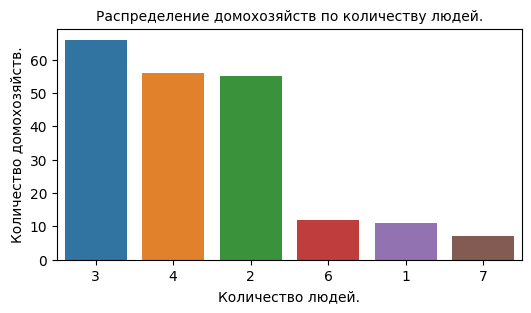

In [20]:
plt.figure(figsize=(6, 3))
my_plot = sns.countplot(x = 'кол-во_человек_в_семье_4+', data = sur,
                        order=sur['кол-во_человек_в_семье_4+'].value_counts().index);
plt.title('Распределение домохозяйств по количеству людей.', size=10)
plt.xlabel('Количество людей.', size=10)
plt.ylabel('Количество домохозяйств.', size=10)
my_plot.set_xticklabels(my_plot.get_xticklabels(),
                        horizontalalignment='center')

plt.show()

Больше всего домохозяйст с 3 членами семьи. Далее идут те, где 4 и 2 члена семьи. Максимально в домохозяйстве зафиксировано 7 членов семьи.

## <a id='toc1_4_'></a>[Общий вывод](#toc0_)

Данные по опросу пользователей телевизоров собраны в период с 2024-04-05 03:05:31 по  2024-04-05 21:00:16.

В файле src_OnOff.csv находится 642_134 записи по фактическому включению/выключению пиплметра, а в файле src_survey.csv - выборка из 207 записей с результатами опроса клиентов телевизионной компании.

Была проведена предобработка и выполнен анализ.

Количество ситуаций, когда прибор фактически выключен, а респондент утверждает, что включен, равно: 9.
В процентном отношении такое количество: **4.35%**.

Количество ситуаций, когда прибор фактически включен, а респондент утверждает, что выключен, равно: 43.
В процентном отношении такое количество: **20.77%**.

**Домохозяйств с условиями**:
- телевизор фактически включен: [x['devicestate'] == 'ON'],
- респондент находится в комнате: [x['display'] == 'в комнате'],
- респондент с включенным телевизором: [x['tv_state'] == 'включён'],
- регистрации нет: [x['see'] == 'нет регистрации']
- у других респондентов в этом ДХ регистрация на этом телевизоре есть

**не существует**.

Больше всего домохозяйст с 3 членами семьи. Далее идут те, где 4 и 2 члена семьи. Максимально в домохозяйстве зафиксировано 7 членов семьи.